# Estudo de caso 1.3: *PCA* - Identificação facial

---
<br>

**Recursos extras:**

* Roteiro do estudo de caso
* Artigo original de Matthew A. Turk e Alex P. Pentland: [Face Recognition Using Eigenfaces](http://www.mit.edu/~9.54/fall14/Classes/class10/Turk%20Pentland%20Eigenfaces.pdf)
* Estudo de caso de JHU: [Eigenfaces for Face Detection/Recognition](http://www.vision.jhu.edu/teaching/vision08/Handouts/case_study_pca1.pdf)
* Entradas de blogs:
    * [EigenFaces and A Simple Face Detector with PCA/SVD in Python](https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/)
    * [How to Get Eigenfaces](https://medium.com/@lwj.liuwenjing/how-to-get-eigenfaces-a9caeeba8767) ([source code](https://colab.research.google.com/drive/1T3cSvQZjKhh8s3Dxrb9gPCWhwhcz4Bmo#scrollTo=q2mPsa4M3Jkc)
    * [Eigenfaces: Recovering Humans from Ghosts](https://towardsdatascience.com/eigenfaces-recovering-humans-from-ghosts-17606c328184)
    
<br>

---


Configuração do notebook:

Sincronize sua conta do Google. Para isso, siga o link que aparece na saída da seguinte célula uma vez executada. Copie o código que aparece na tela e insira-o na saída da célula.

Esta célula também permitirá a você importar o banco de dados que será usado neste estudo de caso.

Assim que visualizar a mensagem: `Google Drive sincronizado e banco de dados importado com sucesso!` poderá continuar executando o restante das células.

In [ ]:
from google.colab import auth, drive
auth.authenticate_user()

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import zipfile

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

data_drop = drive.CreateFile({'id':'1Ef3kc82CVbUAqudU1gKs0rxxKC25jdaq'})
data_drop.GetContentFile('training_set.zip')
with zipfile.ZipFile('training_set.zip', 'r') as zip_ref:
    zip_ref.extractall('')

data_drop = drive.CreateFile({'id':'1OfGSJGEzQENEUDL-yGem0fb_zV1og2Lo'})
data_drop.GetContentFile('test_set.zip')
with zipfile.ZipFile('test_set.zip', 'r') as zip_ref:
    zip_ref.extractall('')

print('Google Drive sincronizado e banco de dados importado com sucesso!')

Google Drive sincronizado e banco de dados importado com sucesso!


Importar bibliotecas necessárias:

In [ ]:
!pip uninstall -y scikit-image
#!pip install -q scikit-image==0.16.2
!pip install -q scikit-image==0.19.3

Found existing installation: scikit-image 0.19.3
Uninstalling scikit-image-0.19.3:
  Successfully uninstalled scikit-image-0.19.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 19.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
from sklearn.preprocessing import normalize
import os

#Visualização
import matplotlib.pyplot as plt
#import skimage
from skimage import img_as_ubyte, io, color, transform, exposure


print('\nBibliotecas importadas com sucesso!')


Bibliotecas importadas com sucesso!


In [ ]:
!pip install -q ludwig[image]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 874.5/874.5 kB 6.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.8/80.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 9.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━

# Banco de dados

---
<br>

Neste exemplo, utilizamos o banco de dados público [LFWcrop](http://conradsanderson.id.au/lfwcrop/), desenvolvido por Conrad Sanderson. Este banco de dados é um subconjunto de um banco de dados maior chamado [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/) (LFW), muito utilizado em _Computer vision_.

Este banco de dados é composto por imagens de 64x64 pixels, contendo rostos de pessoas. As imagens estão cortadas de forma que o rosto ocupe toda a imagem. A versão em escala de cinza de todas as imagens pode ser encontrada em [`Data/lfwcrop_grey_faces`](https://drive.google.com/drive/folders/1sdDB6utZeRGOgfF7PZhk6wTj3Qhjv1Fm?usp=sharing). O banco de dados conta com 13233 imagens, mas neste exemplo usaremos 100.

<br>

---


O banco de dados contém mais de uma imagem para algumas pessoas. O conjunto de treinamento deve estar composto por 100 (M) imagens de pessoas __diferentes__. Podem ser explorados outros tamanhos do conjunto de treinamento.

In [ ]:
#Número de imagens no conjunto de treinamento (max 100)
M = 100
print('Tamanho do conjunto de treinamento: {} imagens'.format(M))

#Definir tamanho das imagens
irow,icol = (64,64)


#Importar os nomes das M primeiras imagens do conjunto de treinamento
dir_='training_set/'
training_set_filenames = os.listdir(dir_)
training_set_filenames.remove('.DS_Store')

Tamanho do conjunto de treinamento: 100 imagens


Podemos importar as imagens, "achatá-las" (transformar uma matriz de $N_1xN_2$ pixels em um vetor de $N_1xN_2$ valores de comprimento) e armazená-las em uma matriz (`S_raw`).

In [ ]:
S_raw = np.ndarray((irow*icol,M))

for i in range(M):
    #Ler img
    img = io.imread('training_set/{}'.format(training_set_filenames[i]))
    #img = color.rgb2gray(img)
    img = transform.resize(img, (irow,icol),anti_aliasing=True)
    #Adicionar img à matriz
    S_raw[:,i]= img.flatten()

print('Dimensões de S_raw: {}'.format(S_raw.shape))
print('S_raw dtype: {}'.format(S_raw.dtype))

Dimensões de S_raw: (4096, 100)
S_raw dtype: float64


## Funções auxiliares

Algumas funções auxiliares para visualizar as imagens durante o estudo de caso.

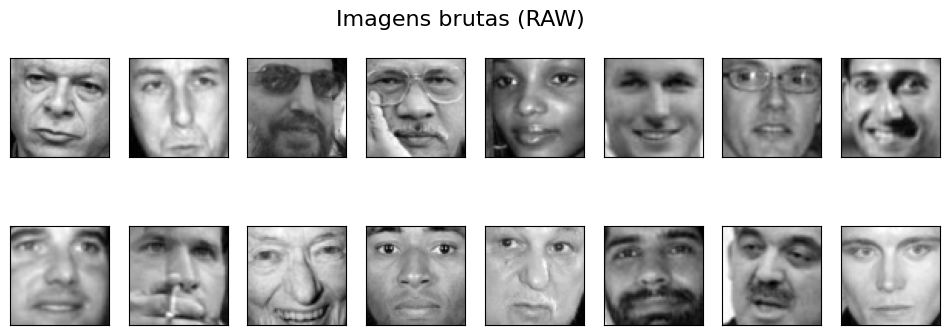

In [ ]:
def plot_images(S,title=''):
    S = S[:,:16].copy()
    fig, axes = plt.subplots(nrows=round(S.shape[1]/8), ncols=8,figsize=(12,4))
    plt.subplots_adjust(wspace = 0.2,hspace = 0.2)
    ax = axes.ravel()
    fig.suptitle(title, fontsize = 16, y=0.95)
    for i in range(S.shape[1]):
        #Mostrar as img
        ax[i].imshow(S[:,i].reshape((irow,icol)), cmap='gray')
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)
    plt.show()

plot_images(S_raw,title='Imagens brutas (RAW)')

# Pré-processamento de imagens


Para condicionar o conjunto de treinamento, convém padronizar (fazer com que todas as imagens tenham a mesma média e desvio padrão) e centralizar cada imagem (subtrair a imagem média de todo o conjunto de cada imagem).

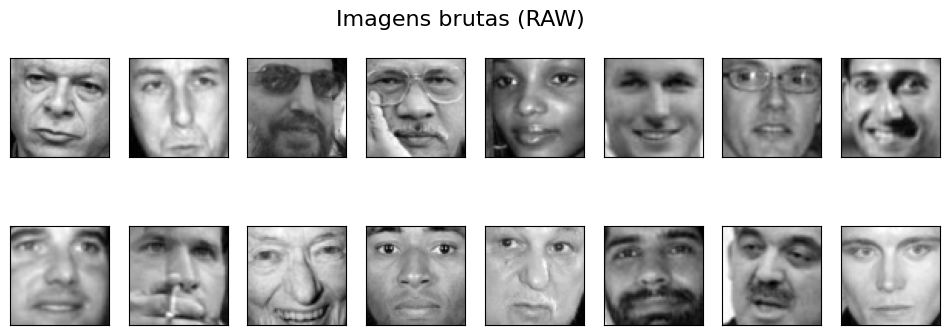

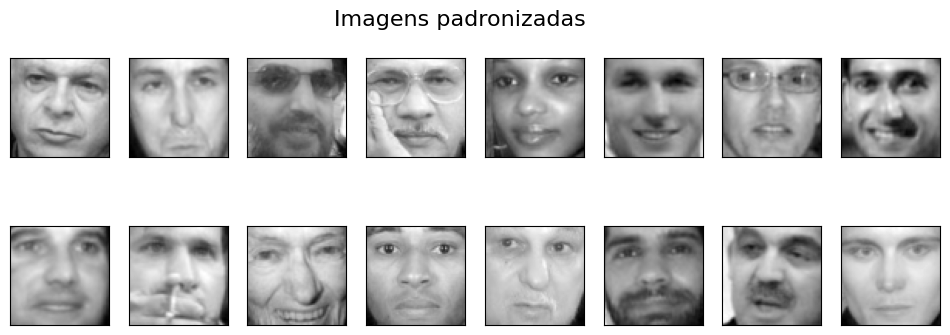

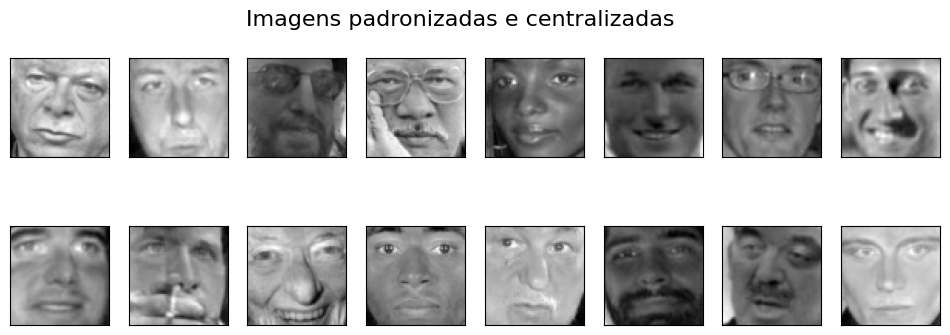

In [ ]:
S_processed = S_raw.copy()
plot_images(S_raw,title='Imagens brutas (RAW)')
#Padronização
um = S_processed.mean(axis=1)
ustd = S_processed.std(axis=1)
for i in range(M):
    S_processed[:,i] = (S_processed[:,i] - S_processed[:,i].mean()) * ustd/S_processed[:,i].std() + um

plot_images(S_processed,title='Imagens padronizadas')

#Centralizado
mean_img = S_processed.mean(axis= 1)
for i in range(M):
    S_processed[:,i] = S_processed[:,i] - mean_img

plot_images(S_processed,title = 'Imagens padronizadas e centralizadas')


Tambem podemos visualizar a "imagem média":

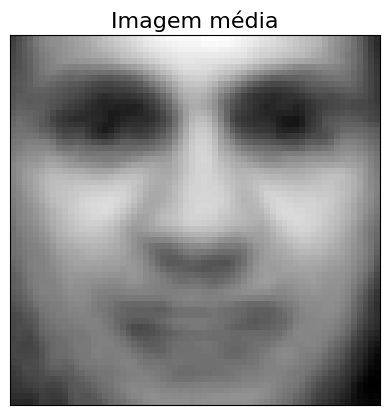

In [ ]:
ax,fig = plt.subplots()
plt.imshow(img_as_ubyte(mean_img.reshape((irow,icol))), cmap='gray')
plt.title('Imagem média',fontsize= 16)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show()

# Calculando as "eigenfaces"

As _eigenfaces_ são os autovetores da matriz de covariância do conjunto de treinamento.

Tomemos A como nosso conjunto de faces (achatadas e centralizadas e subtraindo a média). Então, a matriz de covariância $C$ é calculada da seguinte forma: $C = AA^T$. No entanto, esta matriz é muito grande ($N^2xN^2$) e seu cálculo pode ser muito difícil a nível computacional. De modo que podemos considerar a matriz $L = A^TA$, que é muito menor ($MxM$), e cujos $M$ autovetores (e seus correspondentes autovalores) permitem o cálculo dos autovetores de $C$ associados aos seus $M$ maiores autovalores:


In [ ]:
#Matriz de covariância C=AA'
#Calculamos L=A'A porque C é muito grande e difícil de calcular
print('Calculando L = A\'A...')
A = S_processed.copy()
L = np.matmul(A.T,A)
print('Dimensões de L: {}\n'.format(L.shape))

#Calculando os autovetores e autovalores de L
print('Calculando os autovetores e autovalores de L...')
dd, vv = np.linalg.eig(L)
#vv são os autovetores de L
#dd são os autovalores de L e C
print('Dimensões do conjunto de autovetores vv: {}'.format(vv.shape))
print('||vv_0||= {} (já está padronizado)\n'.format(np.linalg.norm(vv[:,0])))
#Eliminando os autovetores com autovalor = 0
print('Eliminando os autovetores com autovalor = 0 (e seus autovetores correspondentes)\n')
threshold = 1e-4
n = sum(dd > threshold)
d = np.zeros(n)
v = np.zeros((vv.shape[0],n))
j = 0
for i in range(len(dd)):
    if dd[i] > threshold:
        d[j] = dd[i]
        v[:,j] = vv[:,i]
        j += 1
    else:
        print('Eliminando dd[{}] e vv[{}] (dd[{}]={})'.format(i,i,i,dd[i]))
#Organizando (ascendente)
v = v[:,np.argsort(d)]
d = np.sort(d)
print('||v_0||= {} (já está padronizado)\n'.format(np.linalg.norm(v[:,0])))

#Autovetores da matriz C
print('Calculating the {} higher eigenvectors and eigenvalues of C = AA\' (covariance matrix)...'.format(n))
u = np.matmul(A,v)
print('Dimensões de u: {}'.format(u.shape))

#Padronização de C
print('||u_0||= {}\n'.format(np.linalg.norm(u[:,0])))
print('Padronizando os autovetores da matriz C...')
u = normalize(u, axis = 0)
print('||u_0||= {}'.format(np.linalg.norm(u[:,0])))


Calculando L = A'A...
Dimensões de L: (100, 100)

Calculando os autovetores e autovalores de L...
Dimensões do conjunto de autovetores vv: (100, 100)
||vv_0||= 1.0 (já está padronizado)

Eliminando os autovetores com autovalor = 0 (e seus autovetores correspondentes)

Eliminando dd[44] e vv[44] (dd[44]=-7.360159802491224e-15)
||v_0||= 1.0 (já está padronizado)

Calculating the 99 higher eigenvectors and eigenvalues of C = AA' (covariance matrix)...
Dimensões de u: (4096, 99)
||u_0||= 2.0502321965823667

Padronizando os autovetores da matriz C...
||u_0||= 1.0000000000000016


Uma vez que temos os autovetores u<sub>i</sub>, se os transformamos de novo em imagens de NxN pixels podemos obter as _eigenfaces_:

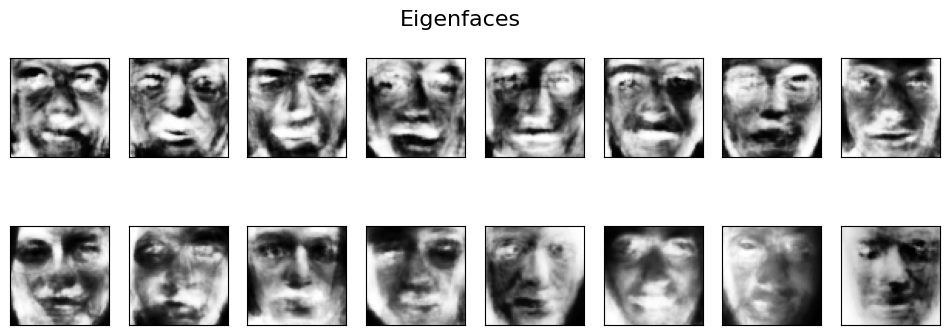

In [ ]:
#Mostrar as eigenfaces
eigen_faces = np.ndarray((irow*icol,u.shape[1]))
for i in range(u.shape[1]):
    eigen_faces[:,i] = exposure.equalize_hist(u[:,i],nbins=256)
eigen_faces = img_as_ubyte(eigen_faces)
plot_images(eigen_faces[:,-16:],title = 'Eigenfaces')

# Reconstruindo e classificando novos rostos


Uma aplicação possível das _eigenfaces_ é reconstruir imagens que não estão dentro do conjunto de treinamento. Neste estudo, são tomadas 16 imagens do banco de dados:

Tais imagens podem ser reconstruídas como combinação linear das _eigenfaces_:

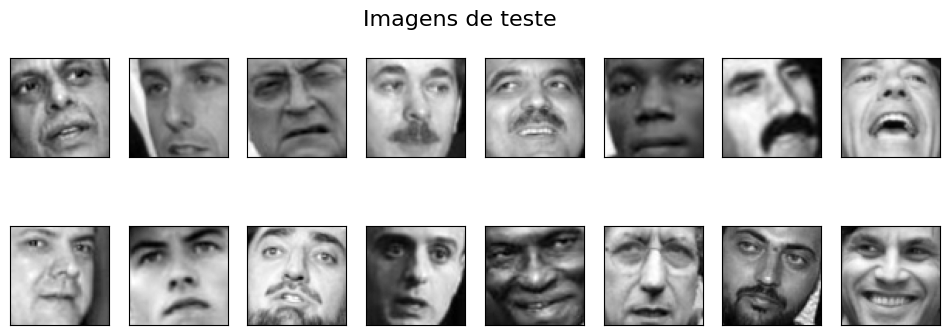

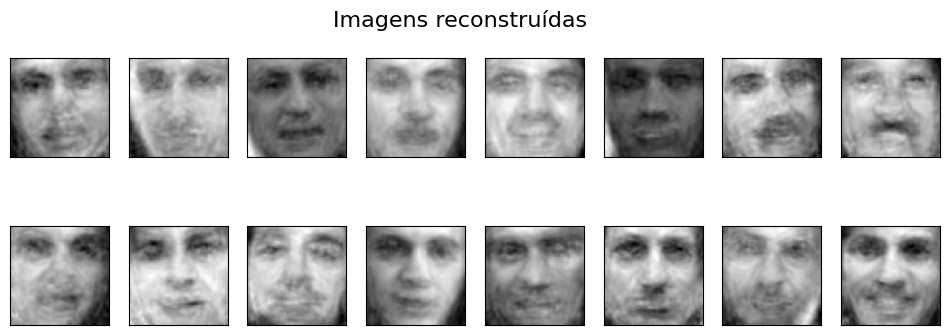

In [ ]:
T=16

#Importar os nomes das 16 primeiras imagens do conjunto de teste
dir_='test_set/'
test_set_filenames = os.listdir(dir_)
test_set_filenames.remove('.DS_Store')

S_test_raw = np.ndarray((irow*icol,T))
for i in range(T):
    #Ler img
    img = io.imread('test_set/{}'.format(test_set_filenames[i]))
    #img = color.rgb2gray(img)
    img = transform.resize(img, (irow,icol),anti_aliasing=True)
    #Adicionar img à matriz
    S_test_raw[:,i]= img.flatten()

#Padronização
S_test = S_test_raw.copy()
for i in range(T):
    S_test[:,i] = (S_test[:,i] - S_test[:,i].mean()) * ustd/S_test[:,i].std() + um

#Centralizado
for i in range(T):
    S_test[:,i] = S_test[:,i] - mean_img

S_reshaped = np.ndarray((irow*icol,T))
for i in range(T):
    S_reshaped[:,i] = mean_img + np.dot(np.dot(u.T,S_test[:,i]),u.T)

#Mostrar as img de entrada e as reconstruídas
plot_images(S_test_raw,title = 'Imagens de teste')
plot_images(S_reshaped,title = 'Imagens reconstruídas')

Também se pode calcular a distância (dissimilaridade) entre os rostos do conjunto de teste e os do conjunto de treinamento:


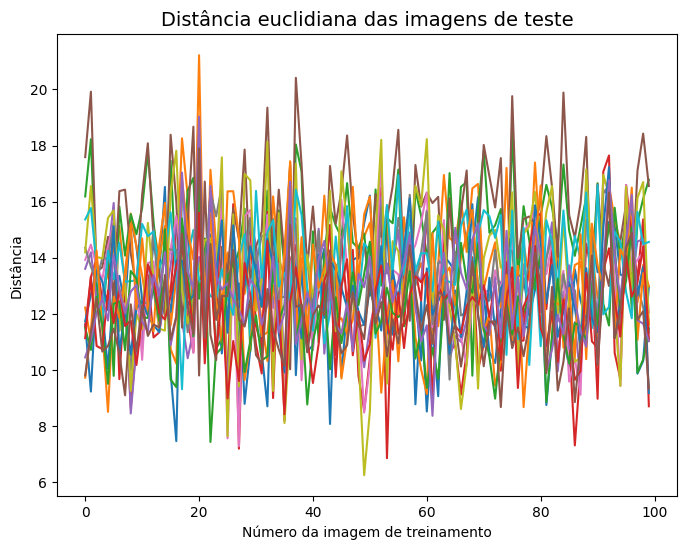

In [ ]:
#Cálculo do peso das eigenfaces na nova imagem
weights = np.zeros((u.shape[1],T))
for i in range(T):
    weights[:,i] = np.dot(u.T,S_test[:,i])

omega = np.zeros((u.shape[1],A.shape[1]))
for h in range(A.shape[1]):
    omega[:,h] = np.dot(u.T, A[:,h].T)

#Encontrar a distância
e = np.zeros((omega.shape[1],T))
for i in range(T):
    for j in range(omega.shape[1]):
        diff_weight = weights[:,i] - omega[:,j]
        e[j,i] = np.linalg.norm(diff_weight)

ax, fig = plt.subplots(figsize=(8,6))
plt.plot(e)
plt.title('Distância euclidiana das imagens de teste',fontsize = 14)
plt.xlabel('Número da imagem de treinamento')
plt.ylabel('Distância')
plt.show()